In [66]:
import numpy as np
import pandas as pd
import math
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from numpy import random
import matplotlib.pyplot as plt

In [13]:
from sklearn.datasets import load_digits

In [330]:
#Loads in the digit data set 
digits = load_digits()
X, y = digits.data, digits.target

In [55]:
#This function just returns a set of indices that you pass into the actual data arrays X,y
def bootstrap_sample(n_sets,num_train_samples,len_data):
    data= []
    for i in range(n_sets):
        set_i = random.permutation(len_data)
        train_indices, test_indices = set_i[:num_train_samples], set_i[num_train_samples:] 
        data.append([train_indices, test_indices])
    return data

In [214]:
#Example of this 
bs_indices = bootstrap_sample(1,len(X_train),len(X))

In [215]:
#Can split into train and test
Xtr = X[bs_indices[0][0]]
ytr = y[bs_indices[0][0]]
Xte = X[bs_indices[0][1]]
yte = y[bs_indices[0][1]]

In [182]:
# just a dataset 
good_tree_X, good_tree_y = Xtr, ytr

In [108]:
#this is a good tree with 10 different labels 
#clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
#clf = clf.fit(Xtr,ytr)

In [209]:
#from bs 3
clf2 = tree.DecisionTreeClassifier(max_leaf_nodes=10)
clf2 = clf2.fit(Xtr,ytr)

In [205]:
#Class labels for plotting
classes = ['0','1','2','3','4','5','6','7','8','9']

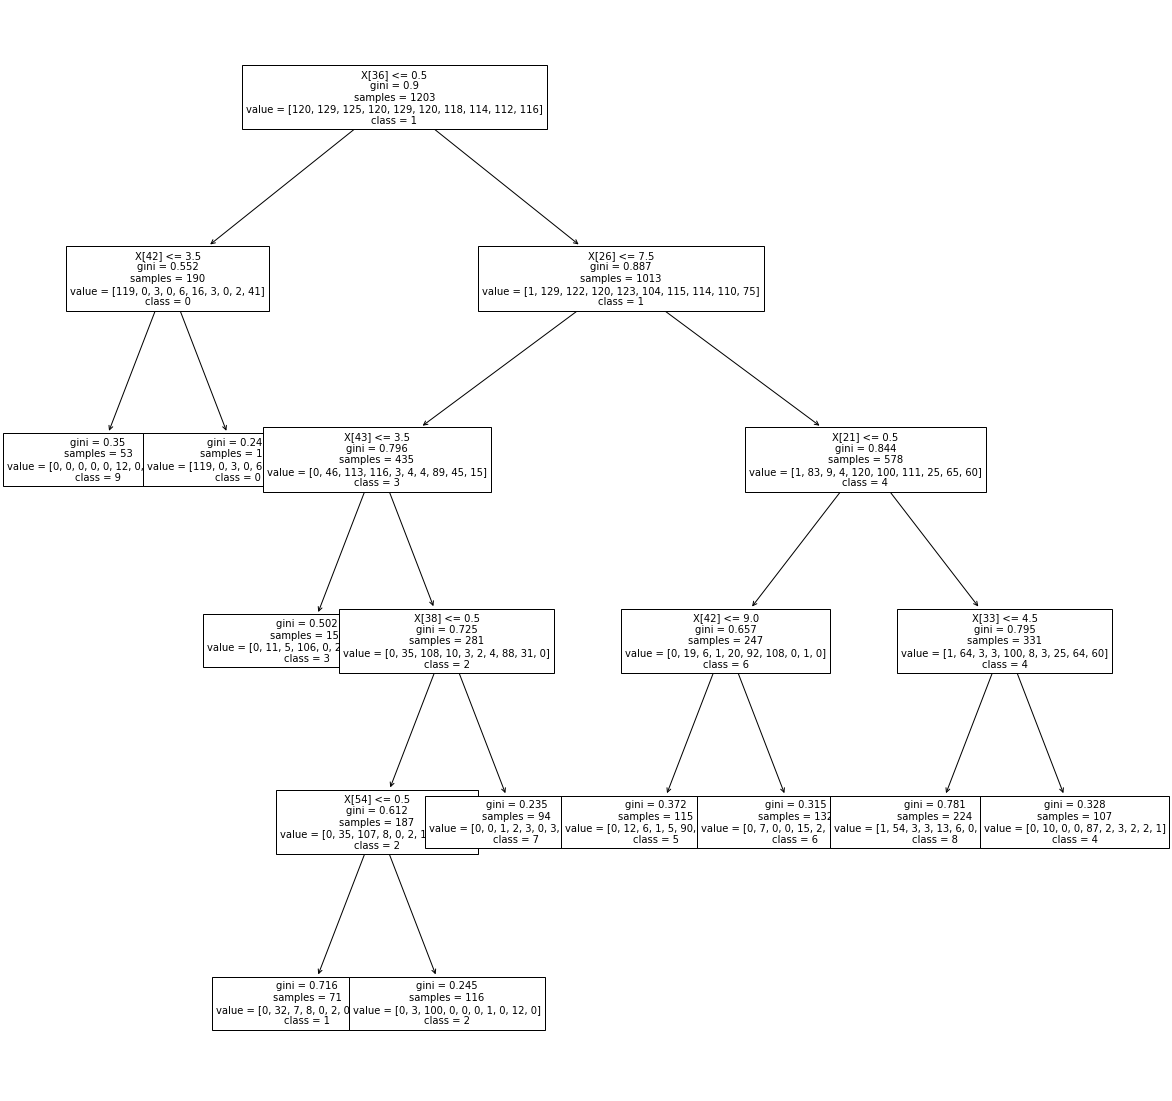

In [292]:
#Plots tree 
fig, ax1 = plt.subplots(figsize = (20,20))
tree.plot_tree(clf, class_names = classes, fontsize = 10, ax = ax1) 
plt.show()

In [114]:
#Example of preformance report, not super important
print('Performance on training data')
print(classification_report(yte,
  clf.predict(Xte)))

Performance on training data
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        58
           1       0.30      0.26      0.28        53
           2       0.83      0.77      0.80        52
           3       0.67      0.83      0.74        63
           4       0.80      0.69      0.74        52
           5       0.73      0.73      0.73        62
           6       0.84      0.84      0.84        63
           7       0.84      0.65      0.73        65
           8       0.26      0.50      0.35        62
           9       0.64      0.22      0.33        64

    accuracy                           0.64       594
   macro avg       0.68      0.64      0.64       594
weighted avg       0.68      0.64      0.64       594



In [319]:
#Function returns newick format, lengths is a dummy ar rn that could define how you label the length
#Also returns a boolean good, if true, the tree contains 10 different trees (we can find it in tree space)
def get_newick(clf, lengths):

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    #feature = clf.tree_.feature
    #threshold = clf.tree_.threshold
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    #is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    labels = [np.argmax(v) for v in clf.tree_.value]
    represented_labels = []
    
    def newick_from_node(node):
        node_id = node[0]
        node_depth[node_id] = node[1]
        if children_left[node_id] != children_right[node_id]:
            left_string = newick_from_node([children_left[node_id],node_depth[node_id]+1])
            right_string = newick_from_node([children_right[node_id],node_depth[node_id]+1])
            if node_depth[node_id] > 0:
                string = '(' + right_string +','+left_string + ')' + ':1'
            else:
                string = '(' + right_string +','+left_string + ')'
            #if lengths == True:
            #could add functionality here
            return string
        else:
            represented_labels.append(labels[node_id])
            return str(labels[node_id])
    
    
    #newick =  '('+ newick_from_node([0,0])+ ');'
    newick =   newick_from_node([0,0])+ ';'
    good = True
    if len(set(represented_labels)) != 10:
        good = False
    return newick, good

In [320]:
#Example
nw, goodness = get_newick(clf, False)

In [321]:
nw

'((((4,8):1,(6,5):1):1,((7,(2,1):1):1,3):1):1,(0,9):1);'

In [343]:
#This will perturb data bootstrap_number of times and then return the forest of 'good' trees. each tree is a tuple
#forest[i] gives you the tuple, index 0 is the tree in newick, index 1 is its accuracy on the corresponding test 
#Note that each tree is evaluated on the data it has never seen
def find_good_trees(bootstrap_number):
    indices = bootstrap_sample(bootstrap_number,len(X_train),len(X))
    forest = []
    for i in range(bootstrap_number):
        Xtr = X[indices[i][0]]
        ytr = y[indices[i][0]]
        Xtst = X[indices[i][1]]
        ytst = y[indices[i][1]]
        dt = tree.DecisionTreeClassifier(max_leaf_nodes=10)
        dt = dt.fit(Xtr,ytr)
        nw, good = get_newick(dt, False)
        if good == True:
            forest.append([nw,dt.score(Xtst,ytst)])
    return forest

In [344]:
forest_test = find_good_trees(500)

In [345]:
forest_test[0][0]

'(((4,(((8,2):1,3):1,7):1):1,(6,(5,1):1):1):1,(0,9):1);'

In [275]:
#makes a file that the algo takes
def file_out(tree1, tree2, filename):
    f = open(filename, "a")
    f.write(tree1+'\n'+tree2)
    f.close()

In [324]:
file_out(forest_test[0][0],forest_test[1][0],'tree_test.txt')

In [277]:
#Below I was just messing around with the iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
Xiris, yiris = iris.data, iris.target
iris_tree = tree.DecisionTreeClassifier(max_leaf_nodes=3)
irirs_tree = iris_tree.fit(Xiris, yiris)

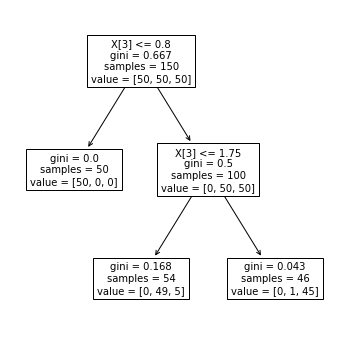

In [280]:
fig, ax1 = plt.subplots(figsize = (6,6))
tree.plot_tree(irirs_tree, fontsize = 10, ax = ax1) 
plt.show()

In [298]:
newick_iris, quality = get_newick(iris_tree, False)

In [346]:
newick_iris

'(0,(1,2):1);'

In [303]:
file_out(newick_iris,newick_iris,'gtp_170317/tree_iris.txt')

In [ ]:
(((((8:1,4:1):1,(5:1,6:1):1):1,(3,(7,(1,2):1):1):1):1,(0,9):1));
(((((5:1,4:1):1,(8:1,6:1):1):1,(3,(7,(1,2):1):1):1):1,(0,9):1));